In [1]:
import tensorflow as tf
import numpy as np
import sys

from sklearn.metrics import mean_squared_error
from keras.callbacks import LearningRateScheduler

from tensorflow.python import debug as tf_debug
#from sklearn.preprocessing import MinMaxScaler ##########

#sys.path.append('/Users/davidlaredorazo/Documents/University_of_California/Research/Projects')
#sys.path.append('/media/controlslab/DATA/Projects')
sys.path.append('/Users/Think/Desktop/project')

#Tunable model
from ann_framework.tunable_model.tunable_model import SequenceTunableModelRegression

#Data handlers
from ann_framework.data_handlers.data_handler_Grid import GridDataHandler

#Custom modules
from ann_framework import aux_functions

import aux_functions_stochastic
import analytic_functions
import loss_functions

import matplotlib.pyplot as plt


D:\Anaconda3\Anaconda3_Python6\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#declare specifics of the ODE
deltas = [10**(-5)]
variable_boundaries = [[0, 1]]
points_per_dimension = [1000]

#Boundary conditions
initial_xs = np.array([[0]])
initial_ys = np.array([[1]])

num_features = len(points_per_dimension)
num_conditions = len(initial_xs)
num_output = 1

#two d-dimensional points for each dimension to compute the derivatives plus the original point
num_fevals = len(points_per_dimension)*2+1 

### Define tensorflow model

In [3]:
def create_placeholders(input_shape, output_shape):
    
    X = tf.placeholder(tf.float32, shape=(None,input_shape), name="X")
    y = tf.placeholder(tf.float32, shape=None, name="y")
    
    return X, y

def tf_simple_ode(X):
    
    #l2_lambda_regularization = 0.1
    #l1_lambda_regularization = 0.10
    
    A1 = tf.layers.dense(X, 50, activation=tf.nn.relu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False), 
                         name="fc1")
    A2 = tf.layers.dense(A1, 10, activation=tf.nn.relu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False), 
                         name="fc2")
    y = tf.layers.dense(A1, 1, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                        name="out")
    
    return y


### Create Model TF

In [4]:
def tf_compiled_model(num_features, output_shape, num_fevals=1, num_conditions=0, alpha=1):
    tf.reset_default_graph()

    X, y = create_placeholders(num_features, output_shape)
    y_pred = tf_simple_ode(X)
    
    loss_function =  loss_functions.residual_function_wrapper(num_features, output_shape, 
                                                                     deltas, num_fevals, num_conditions, alpha)
    cost, e = loss_function(X, y_pred, y)
    #reg_cost = tf.losses.get_regularization_loss()
    total_cost = cost
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01, beta1=0.5).minimize(total_cost)

    return {'X_placeholder': X, 'y_placeholder': y, 'y_pred': y_pred, 'cost': cost, 'total_cost': total_cost, 'optimizer': optimizer}

## Create Tunable Model Tensorflow and assign data

### For simple ODE

In [5]:
#scaler = MinMaxScaler()

dhandler_grid = GridDataHandler()

model = tf_compiled_model(num_features=num_features, output_shape=num_output, num_fevals=num_fevals, 
                          num_conditions=num_conditions, alpha=1)

tModel = SequenceTunableModelRegression('ModelStochastic_SN_1', model, lib_type='tensorflow', 
                                        data_handler=dhandler_grid, batch_size=256)

tModel.load_data(verbose=1, cross_validation_ratio=0.2, boundaries=variable_boundaries, n=points_per_dimension)

#Real function
tModel.y_test = analytic_functions.ode2(tModel.X_test[:,0])
tModel.y_train = analytic_functions.ode2(tModel.X_train[:,0])
tModel.y_crossVal = analytic_functions.ode2(tModel.X_crossVal[:,0])

tModel.print_data()

num conditions
1
batch size
Tensor("Cast:0", shape=(), dtype=int32)
Loading data for the first time
Reloading data due to parameter change
Loading data. Cros-Validation ratio 0.2
Printing shapes

Training data (X, y)
(720, 1)
(720, 1)
Cross-Validation data (X, y)
(180, 1)
(180, 1)
Testing data (X, y)
(100, 1)
(100, 1)
Printing first 5 elements

Training data (X, y)
[[0.33363336]
 [0.54705471]
 [0.92439244]
 [0.37783778]
 [0.12061206]]
[[1.39603121]
 [1.72815559]
 [2.52033654]
 [1.45912623]
 [1.12818716]]
Cross-Validation data (X, y)
[[0.22462246]
 [0.02920292]
 [0.9429943 ]
 [0.91019102]
 [0.70057006]]
[[1.25185001]
 [1.02963351]
 [2.56765826]
 [2.48479713]
 [2.01490099]]
Testing data (X, y)
[[0.1490149 ]
 [0.42844284]
 [0.2330233 ]
 [0.0690069 ]
 [0.33933393]]
[[1.16069029]
 [1.53486564]
 [1.2624109 ]
 [1.0714436 ]
 [1.40401211]]


D:\Anaconda3\Anaconda3_Python6\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Train model Tensorflow

In [6]:
tModel.epochs = 100
minibatches_function_handle = aux_functions_stochastic.get_minibatches

sess = tf.Session()

tModel.train_model(tf_session=sess, get_minibatches_function_handle=minibatches_function_handle, 
                   verbose=1, deltas=deltas, initial_xs=initial_xs, initial_ys=initial_ys)

    # cost_reg: total_cost -> e
    # cost: R

Epoch: 0001 cost_reg= 0.203139225 cost= 0.203139225
Epoch: 0002 cost_reg= 0.016558817 cost= 0.016558817
Epoch: 0003 cost_reg= 0.015605099 cost= 0.015605099
Epoch: 0004 cost_reg= 0.011460968 cost= 0.011460968
Epoch: 0005 cost_reg= 0.012109610 cost= 0.012109610
Epoch: 0006 cost_reg= 0.012754486 cost= 0.012754486
Epoch: 0007 cost_reg= 0.012914983 cost= 0.012914983
Epoch: 0008 cost_reg= 0.012439053 cost= 0.012439053
Epoch: 0009 cost_reg= 0.012067785 cost= 0.012067785
Epoch: 0010 cost_reg= 0.010644466 cost= 0.010644466
Epoch: 0011 cost_reg= 0.010517714 cost= 0.010517714
Epoch: 0012 cost_reg= 0.010629950 cost= 0.010629950
Epoch: 0013 cost_reg= 0.013857367 cost= 0.013857367
Epoch: 0014 cost_reg= 0.008910311 cost= 0.008910311
Epoch: 0015 cost_reg= 0.006397867 cost= 0.006397867
Epoch: 0016 cost_reg= 0.006876972 cost= 0.006876972
Epoch: 0017 cost_reg= 0.007176548 cost= 0.007176548
Epoch: 0018 cost_reg= 0.009878289 cost= 0.009878289
Epoch: 0019 cost_reg= 0.011426749 cost= 0.011426749
Epoch: 0020 

Epoch: 0163 cost_reg= 0.036616931 cost= 0.036616931
Epoch: 0164 cost_reg= 0.035998175 cost= 0.035998175
Epoch: 0165 cost_reg= 0.035689251 cost= 0.035689251
Epoch: 0166 cost_reg= 0.036092186 cost= 0.036092186
Epoch: 0167 cost_reg= 0.036019038 cost= 0.036019038
Epoch: 0168 cost_reg= 0.035891348 cost= 0.035891348
Epoch: 0169 cost_reg= 0.035986116 cost= 0.035986116
Epoch: 0170 cost_reg= 0.035087527 cost= 0.035087527
Epoch: 0171 cost_reg= 0.035518707 cost= 0.035518707
Epoch: 0172 cost_reg= 0.035232714 cost= 0.035232714
Epoch: 0173 cost_reg= 0.035270452 cost= 0.035270452
Epoch: 0174 cost_reg= 0.035153041 cost= 0.035153041
Epoch: 0175 cost_reg= 0.034951911 cost= 0.034951911
Epoch: 0176 cost_reg= 0.035327936 cost= 0.035327936
Epoch: 0177 cost_reg= 0.034141436 cost= 0.034141436
Epoch: 0178 cost_reg= 0.034963637 cost= 0.034963637
Epoch: 0179 cost_reg= 0.033889235 cost= 0.033889235
Epoch: 0180 cost_reg= 0.034547095 cost= 0.034547095
Epoch: 0181 cost_reg= 0.033881110 cost= 0.033881110
Epoch: 0182 

In [7]:
display_points = 20

tModel.evaluate_model(['mse', 'rmse'], cross_validation=True, tf_session=sess)
X_test = tModel.X_crossVal
y_pred = tModel.y_predicted
y_real = tModel.y_crossVal
print("scores")

print(X_test)
print(y_real)

cScores = tModel.scores
#rmse = math.sqrt(cScores['score_1'])
rmse2 = cScores['rmse']
mse = cScores['mse']
time = tModel.train_time

total_points = len(y_pred)
sample_array = list(range(total_points))

sample_points = np.random.choice(sample_array, display_points)
print(sample_points)

y_real_sampled = y_real[sample_points]
y_pred_sampled = y_pred[sample_points]
X_sampled = X_test[sample_points,:]

print(y_real_sampled)

i = range(len(y_pred_sampled))


for x, y_real_display, y_pred_display in zip(X_sampled, y_real_sampled, y_pred_sampled):
    print('x {}, Real y {}, Predicted y {}'.format(x, y_real_display, y_pred_display))

#print("RMSE: {}".format(rmse))
print("RMSE2: {}".format(rmse2))
print("MSE: {}".format(mse))
print("Time : {} seconds".format(time))

scores
[[0.22462246]
 [0.02920292]
 [0.9429943 ]
 ...
 [0.4020402 ]
 [0.21622162]
 [0.53275328]]
[[1.25185001]
 [1.02963351]
 [2.56765826]
 ...
 [1.49487143]
 [1.24137747]
 [1.70361638]]
[1341  150    9    4  368    1  658  450  775 1060  131  765 1634  263
  938  631 1573    4 1262  646]
[[1.23840143]
 [1.54117214]
 [1.04008655]
 [2.01490099]
 [2.52513021]
 [1.02963351]
 [1.02932463]
 [2.67727231]
 [1.23123878]
 [2.05355401]
 [1.37854984]
 [1.47497179]
 [2.52816249]
 [2.62924483]
 [1.11986856]
 [1.97855788]
 [1.45533705]
 [2.01490099]
 [1.37841197]
 [1.24535663]]
x [0.21382138], Real y [1.23840143], Predicted y [1.2056161]
x [0.43254325], Real y [1.54117214], Predicted y [1.4716884]
x [0.03930393], Real y [1.04008655], Predicted y [0.9933179]
x [0.70057006], Real y [2.01490099], Predicted y [1.9472765]
x [0.92629263], Real y [2.52513021], Predicted y [2.398499]
x [0.02920292], Real y [1.02963351], Predicted y [0.98103017]
x [0.02890289], Real y [1.02932463], Predicted y [0.98066515]
x

In [8]:
x = np.linspace(0, 1, 100000)
y = analytic_functions.eg1(x)

y = analytic_functions.ode2(x)

In [9]:
# plt.scatter(X_test.flatten(), y_nn,c='r')  #y_pred
# plt.scatter(X_test.flatten(),y_real.flatten(),c='b')  #y_real

# plt.show()

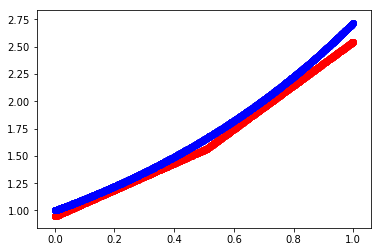

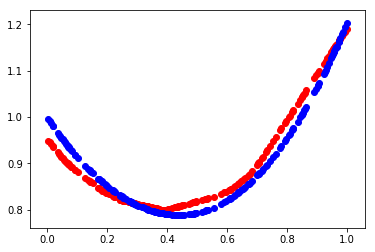

In [11]:
plt.scatter(X_test.flatten(), y_pred.flatten(),c='r')  # y_pred/nn_pred
plt.scatter(X_test.flatten(),y_real.flatten(),c='b')  # y_real
# plt.scatter(x,nn_real,c='b')  #nn_real

# plt.show()